In [5]:
import pandas as pd
# import pandas_profiling as ppf
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
from datetime import datetime 
import numpy as np
import os, random, math, time
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

#score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn.model_selection import cross_val_score

#modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# from mlxtend.evaluate import PredefinedHoldoutSplit

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz



# Warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
def read_file(filename):
    df = pd.read_csv(f'{filename}', encoding="utf-8") #"cp949"
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def read_file2(filename):
    df = pd.read_excel(f'{filename}', header=None)
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

In [7]:
survey_data = read_file('data/surveydata_md2.csv')

...There are no duplicates
shape: (160, 103)


In [4]:
survey_data.isnull().sum().any()

False

# 1. 추가 전처리

아침식전_복용 ~ 취침전_복용의 경우 약_복용알람으로 합치자.

In [5]:
survey_data['약_복용알람'] = survey_data['아침식전_복용'] + survey_data['아침식후_복용'] + survey_data['점심식전_복용'] + survey_data['점심식후_복용'] + survey_data['저녁식전_복용'] + survey_data['저녁식후_복용'] + survey_data['취침전_복용']

필요한 컬럼 선정

In [6]:
regression_data = survey_data[['sex', '기상', '아침', '점심', '저녁', '취침','종교',
                              '약_복용알람', '환기', '산책', '당뇨', '고지혈',
                              '고혈압', '수급여부', '제공서비스','age',
                               '치매', '우울증', '만성복약', '고립', '거동불편', '소리반응', '인형관심',
                               '종교유무', '모니터링', '건강관심', '주택타입', '배우자', '자녀수',
                               '청결', '식사', '공공방문', 'doll_score',
                              '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
                               '신경과수면제_약', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
                               'human_detection', 'gymnastics', 'brain_timer', 'drug_consume','drug_consume_rt',
                               'slife_before','slife_after']]

In [7]:
regression_data = pd.get_dummies(data = regression_data, drop_first = True)

In [8]:
regression_data.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '환기', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '만성복약', '고립', '거동불편', '소리반응', '인형관심',
       '종교유무', '모니터링', '건강관심', '주택타입', '배우자', '자녀수', '식사', '공공방문',
       'doll_score', '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
       '신경과수면제_약', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
       'human_detection', 'gymnastics', 'brain_timer', 'drug_consume',
       'drug_consume_rt', 'slife_before', 'slife_after', 'sex_여', '종교_무교',
       '종교_불교', '종교_천주교', '수급여부_차상위', '청결_중', '청결_하'],
      dtype='object')

column 추가 제거: 기준은 Feature Selection ipynb에 있음

In [9]:
regression_data.drop(['환기', '만성복약', '소리반응', '인형관심', '모니터링', '배우자'], axis = 1, inplace = True)

약을 먹는데 병에 반영이 안 된 사람들 반영

In [10]:
regression_data.loc[:,'당뇨'][(regression_data['당뇨']==0) & (regression_data['당뇨_약']==1)] = 1
regression_data.loc[:,'우울증'][(regression_data['우울증']==0) & (regression_data['우울증_약']==1)] = 1
regression_data.loc[:,'고지혈'][(regression_data['고지혈']==0) & (regression_data['고지혈증_약']==1)] = 1
regression_data.loc[:,'치매'][(regression_data['치매']==0) & (regression_data['치매_약']==1)] = 1

약 지우기

In [11]:
regression_data.drop(['치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약', '신경과수면제_약'], axis = 1, inplace = True)

In [12]:
regression_data.shape

(160, 41)

In [13]:
regression_data.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '고립', '거동불편', '종교유무', '건강관심', '주택타입',
       '자녀수', '식사', '공공방문', 'doll_score', 'med_count', 'stroke',
       'hand_hold_sum', 'knock', 'human_detection', 'gymnastics',
       'brain_timer', 'drug_consume', 'drug_consume_rt', 'slife_before',
       'slife_after', 'sex_여', '종교_무교', '종교_불교', '종교_천주교', '수급여부_차상위', '청결_중',
       '청결_하'],
      dtype='object')

In [14]:
regression_data[['종교유무','종교_무교', '종교_불교', '종교_천주교']][regression_data['종교유무']==regression_data['종교_무교']].shape

(133, 4)

- 일단 다르든 같든 160개가 안되는건 문제가 있다 

In [15]:
regression_data.drop(['종교유무','종교_불교', '종교_천주교'], axis = 1, inplace = True)

## Train/Test Split

In [16]:
from sklearn.model_selection import train_test_split

## 우울증은 점수 높은게 안좋은거고, change는 +가 좋은 것으로 바꿔준 상태

In [17]:
survey_data[['doll_id', 'psy_before', 'psy_after', 'psy_before_cat', 'psy_after_cat', 'psy_change']].head(5)

doll_id  psy_before  psy_after psy_before_cat psy_after_cat  psy_change
0   126401           9         12           위험낮음          고위험군          -3
1   126497           6          6           위험낮음          위험낮음           0
2   126498           3          3           위험낮음          위험낮음           0
3   126500           8         11           위험낮음          고위험군          -3
4   126501           9          4           위험낮음          위험낮음           5

In [18]:
#긍정변화 여부
Y3 = survey_data['psy_change']> 0 

Y3.replace([True, False], [1,0], inplace = True)

In [19]:
X = regression_data

In [20]:
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 123, stratify = Y3)

### *Numeric Data Scaling

In [21]:
X_train.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '고립', '거동불편', '건강관심', '주택타입', '자녀수', '식사',
       '공공방문', 'doll_score', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
       'human_detection', 'gymnastics', 'brain_timer', 'drug_consume',
       'drug_consume_rt', 'slife_before', 'slife_after', 'sex_여', '종교_무교',
       '수급여부_차상위', '청결_중', '청결_하'],
      dtype='object')

기상, 아침, 점심, 저녁, 취침, 약 복용알람, age, 자녀수, doll_score, med_count, stroke, hand_hold_sum, knock, human_detection, gymnastics, brain_timer, drug_consume, slife_before, slife_after

In [22]:
numeric_columns = ['기상', '아침', '점심', '저녁', '취침', '약_복용알람', 'age', '자녀수', 'doll_score', 'med_count', 'stroke',
                   'hand_hold_sum', 'knock', 'human_detection', 'gymnastics', 'brain_timer', 'drug_consume',
                   'slife_before', 'slife_after']

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
min_max_scaler = MinMaxScaler()

#train, test scaling
X_train[numeric_columns] = min_max_scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = min_max_scaler.transform(X_test[numeric_columns])

### Y data split

In [25]:
#긍정변화여부
Y3_train = Y3[list(X_train.index.values)]
Y3_test = Y3[list(X_test.index.values)]

## High Correlation

In [26]:
for i, c1 in enumerate (X_train.columns):
    for j, c2 in enumerate (X_train.columns):
        if (i> j )& (abs(X_train.corr().iloc[i,j])>=0.7):
            print(c1," + ",c2, ' : ', np.round(X_train.corr().iloc[i,j],4))

brain_timer  +  hand_hold_sum  :  0.8127
brain_timer  +  gymnastics  :  0.8742


In [27]:
X_train.drop(['brain_timer'], axis = 1, inplace = True)

X = X[X_train.columns]
X_test = X_test[X_train.columns]

In [28]:
for i, c1 in enumerate (X_train.columns):
    for j, c2 in enumerate (X_train.columns):
        if (i> j )& (abs(X_train.corr().iloc[i,j])>=0.7):
            print(c1," + ",c2, ' : ', np.round(X_train.corr().iloc[i,j],4))

<AxesSubplot:>

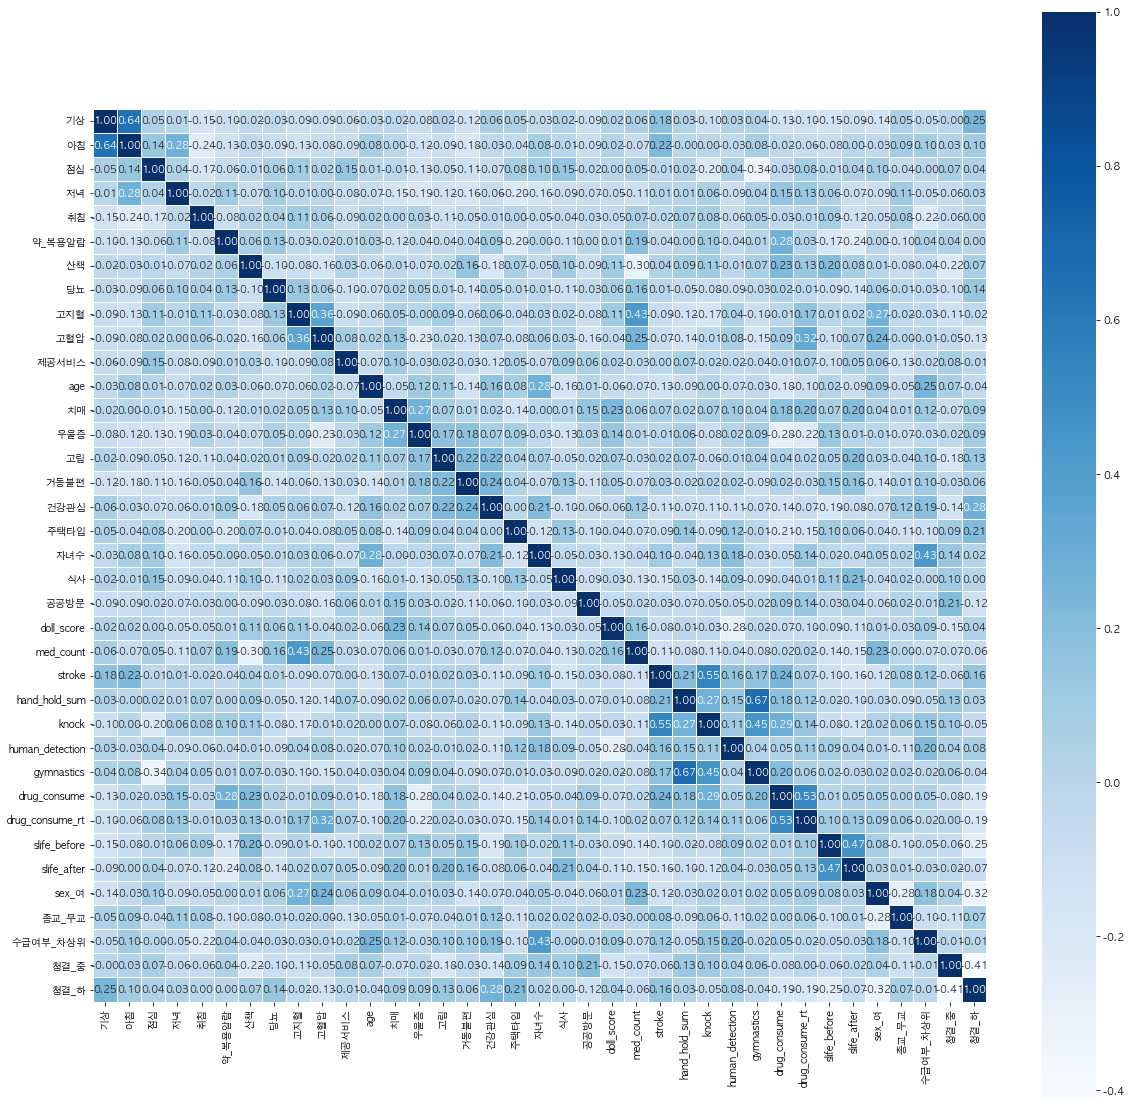

In [29]:
plt.subplots(figsize=(20,20))
sns.heatmap(X_train.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

<AxesSubplot:>

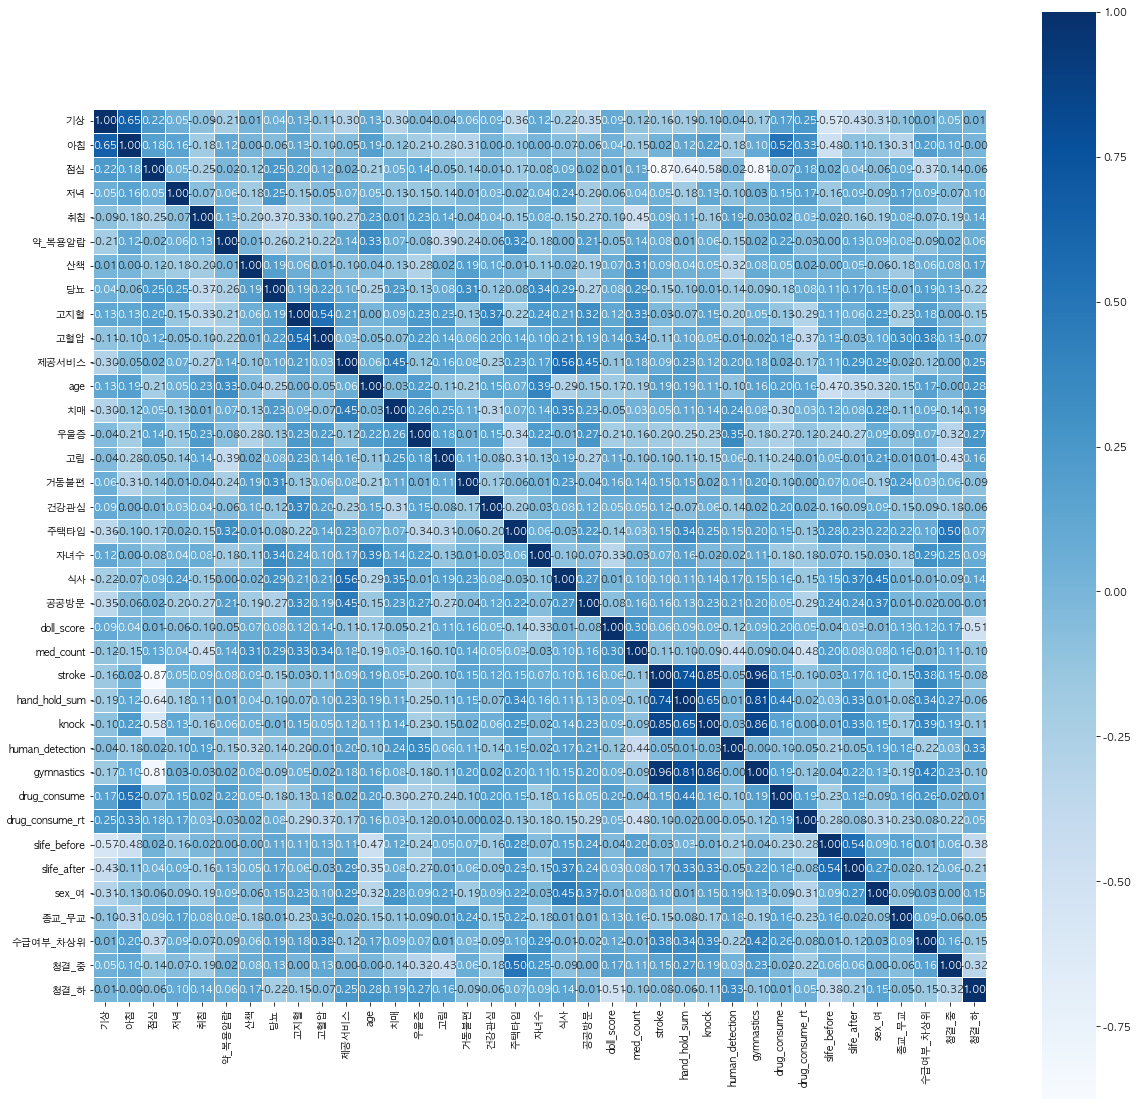

In [30]:
plt.subplots(figsize=(20,20))
sns.heatmap(X_test.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

# 3. 긍정변화여부

In [31]:
print(Y3_train.value_counts())
print(' ')
print(Y3_test.value_counts())

1    82
0    46
Name: psy_change, dtype: int64
 
1    21
0    11
Name: psy_change, dtype: int64


proba 조정할 시 0.6 정도로

## 3-4. RandomForest

In [32]:
rforest_1 = RandomForestClassifier(random_state=11, min_samples_leaf=4, criterion = 'gini')
rforest_1.fit(X_train, Y3_train)

Y3_pred = rforest_1.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

pd.crosstab(Y3_train, Y3_pred)

train_accuracy: 0.890625


col_0        0   1
psy_change        
0           33  13
1            1  81

In [33]:
Y3_pred = rforest_1.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

pd.crosstab(Y3_test, Y3_pred)

test_accuracy: 0.75


col_0       0   1
psy_change       
0           4   7
1           1  20

## cut off 바꾸면 대부분의 경우 좋아지지 않음

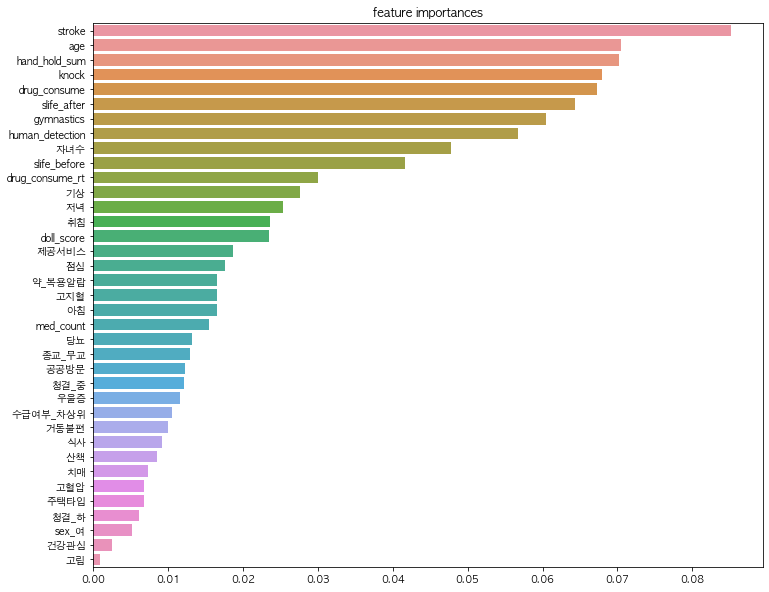

In [34]:
ft_importances = pd.Series(rforest_1.feature_importances_, index = X_train.columns)
ft_importances = ft_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y = ft_importances.index)
plt.show()

In [35]:
f_info = X.columns[np.argsort(rforest_1.feature_importances_)]

In [36]:
col1 = f_info[3:]

In [37]:
rforest_2 = RandomForestClassifier(random_state=171,
                                 min_samples_leaf=4, criterion = 'gini')
rforest_2.fit(X_train[col1], Y3_train)

Y3_pred = rforest_2.predict(X_train[col1])
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

print(pd.crosstab(Y3_train, Y3_pred))

Y3_pred = rforest_2.predict(X_test[col1])
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

print(pd.crosstab(Y3_test, Y3_pred))

train_accuracy: 0.9140625
col_0        0   1
psy_change        
0           36  10
1            1  81
test_accuracy: 0.75
col_0       0   1
psy_change       
0           4   7
1           1  20


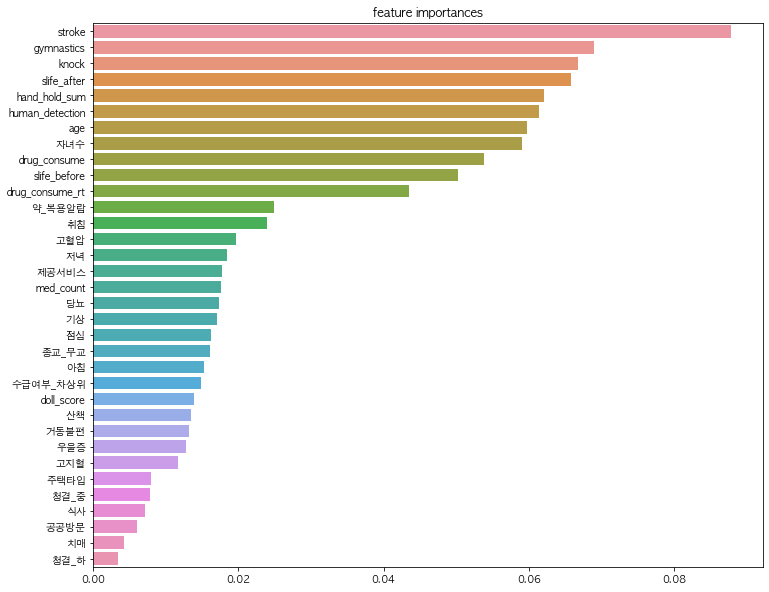

In [38]:
ft_importances = pd.Series(rforest_2.feature_importances_, index = col1)
ft_importances = ft_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y = ft_importances.index)
plt.show()

In [39]:
col2 = ['기상', '점심', '저녁', '취침', '약_복용알람', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '고립', '거동불편', '건강관심', '주택타입', '자녀수', '식사',
       '공공방문', 'med_count', 'doll_score', 
        'stroke', 'hand_hold_sum', 'knock', 'human_detection', 'gymnastics', 'drug_consume', 'drug_consume_rt',
       'slife_before', 'slife_after', 'sex_여', '종교_무교', '수급여부_차상위', '청결_중', '청결_하']

In [40]:
set(X_train.columns) - set(col2)

{'아침'}

In [41]:
rforest_3 = RandomForestClassifier(random_state=171,
                                 min_samples_leaf=3, criterion = 'gini')
rforest_3.fit(X_train[col2], Y3_train)

Y3_pred = rforest_3.predict(X_train[col2])
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu, '\n')

print(pd.crosstab(Y3_train, Y3_pred), '\n')

Y3_pred = rforest_3.predict(X_test[col2])
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu, '\n')

print(pd.crosstab(Y3_test, Y3_pred))

train_accuracy: 0.9609375 

col_0        0   1
psy_change        
0           41   5
1            0  82 

test_accuracy: 0.78125 

col_0       0   1
psy_change       
0           5   6
1           1  20


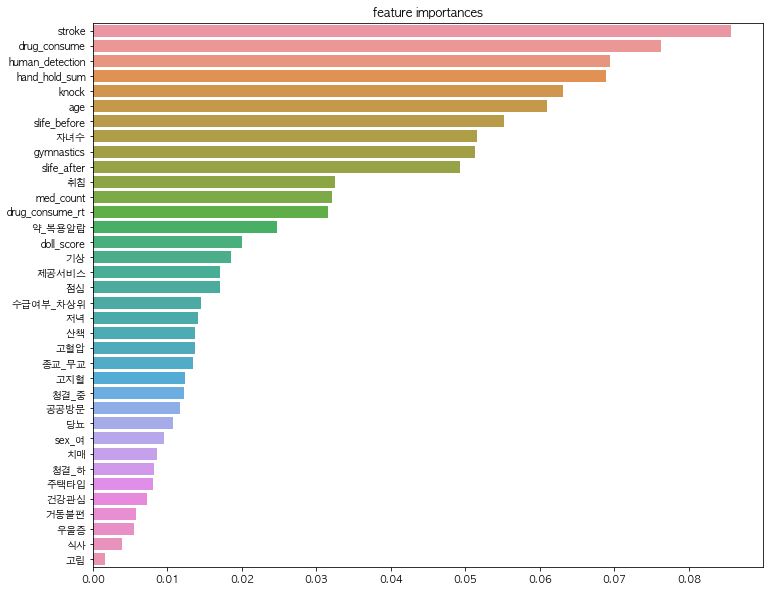

In [42]:
ft_importances = pd.Series(rforest_3.feature_importances_, index = col2)
ft_importances = ft_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y = ft_importances.index)
plt.show()

## 눙물이 난다...

#  SHAP

In [43]:
import shap

In [44]:
X_train_selected = X_train[col2].reset_index(drop=True)
X_test_selected = X_test[col2].reset_index(drop=True)
X_train_selected.columns

Index(['기상', '점심', '저녁', '취침', '약_복용알람', '산책', '당뇨', '고지혈', '고혈압', '제공서비스',
       'age', '치매', '우울증', '고립', '거동불편', '건강관심', '주택타입', '자녀수', '식사', '공공방문',
       'med_count', 'doll_score', 'stroke', 'hand_hold_sum', 'knock',
       'human_detection', 'gymnastics', 'drug_consume', 'drug_consume_rt',
       'slife_before', 'slife_after', 'sex_여', '종교_무교', '수급여부_차상위', '청결_중',
       '청결_하'],
      dtype='object')

In [45]:
rf = RandomForestClassifier(random_state=171,
                                 min_samples_leaf=4, criterion = 'gini')
rf.fit(X_train_selected, Y3_train)

RandomForestClassifier(min_samples_leaf=4, random_state=171)

In [46]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_selected)

## Summary plot

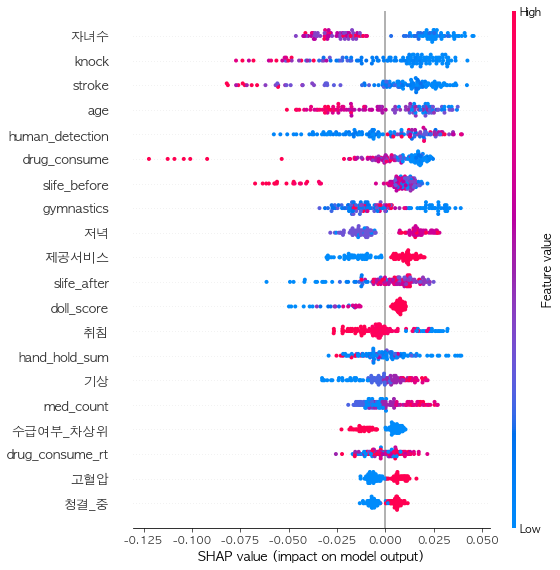

In [50]:
shap.summary_plot(shap_values[1], X_train_selected)

In [51]:
shap.initjs()

In [52]:
idx = 118
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_train_selected.iloc[idx,:])

In [53]:
print('predict 결과:{}'.format(rf.predict(X_train_selected)[idx]))
print('1일 확률:{}'.format(rf.predict_proba(X_train_selected)[idx][1]))

predict 결과:1
1일 확률:0.5474935897435899


우울증 점수가 좋아질 것이라고 예측하였다. age, human_detection이 긍정적인 영향을 주었다. 

In [54]:
idx = 127
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_train_selected.iloc[idx,:])

In [55]:
idx = 80
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_train_selected.iloc[idx,:])

In [56]:
print('predict 결과:{}'.format(rf.predict(X_train_selected)[idx]))
print('1일 확률:{}'.format(rf.predict_proba(X_train_selected)[idx][1]))

predict 결과:1
1일 확률:0.8203726828726827


In [57]:
idx = 110
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_train_selected.iloc[idx,:])

우울증 점수가 좋아질 것이라고 예측하였다. <br>
stroke, gymnastics, knock, human detection 등의 인형 사용 변수가 긍정적인 영향을 주었는데, 그게 그닥 커보이지는 않아서...

## Interaction Plot

In [58]:
shap.initjs()

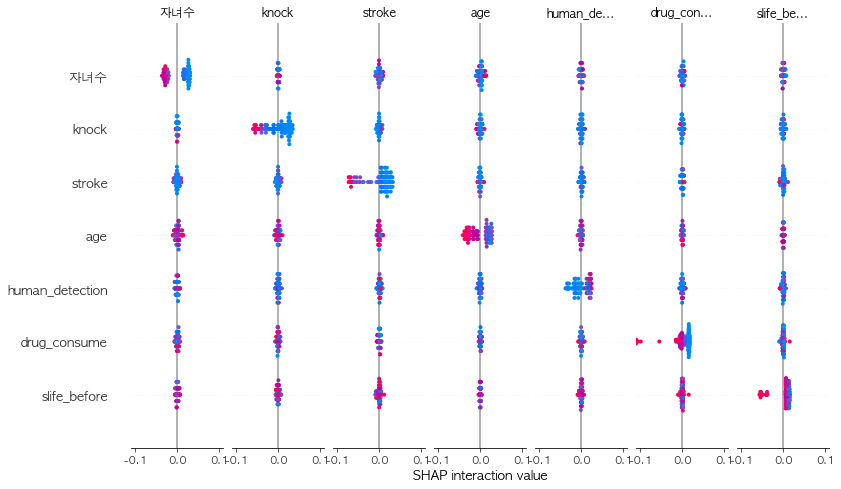

In [60]:
shap_interaction_values = explainer.shap_interaction_values(X_train_selected)
shap.summary_plot(shap_interaction_values[1], X_train_selected)

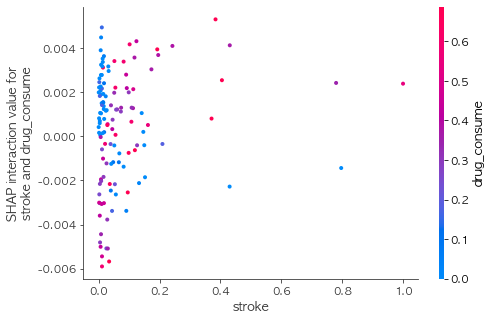

In [61]:
## feature importance 기준 제일 영향력이 높은 2개의 컬럼
shap.dependence_plot(
    ('stroke', 'drug_consume'),
    shap_interaction_values[1], X_train_selected,
    display_features=X_train_selected )

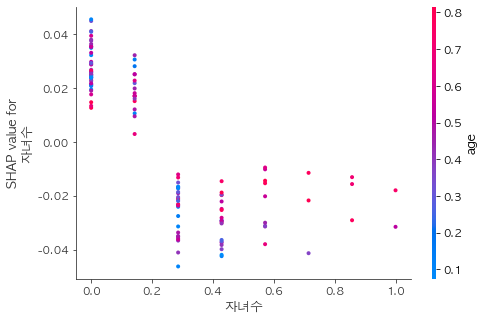

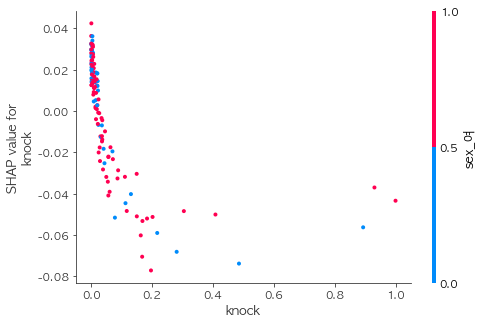

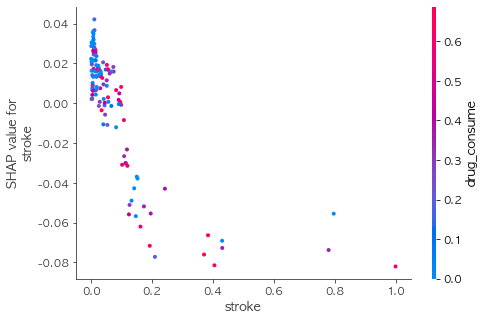

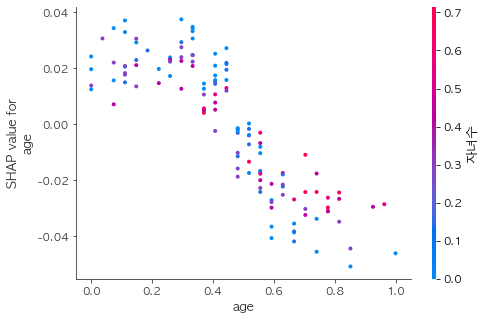

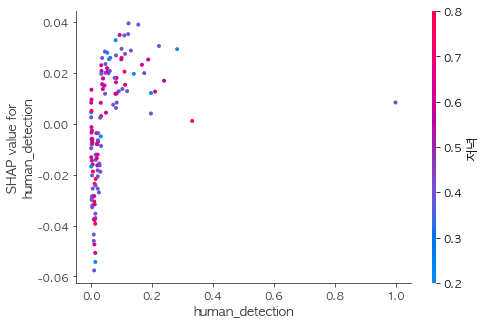

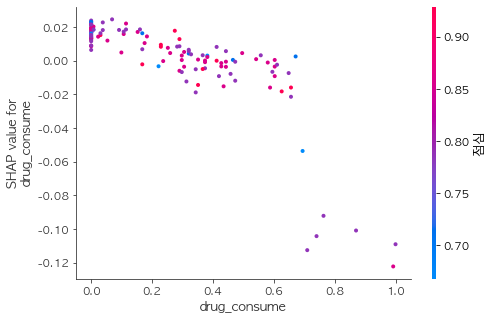

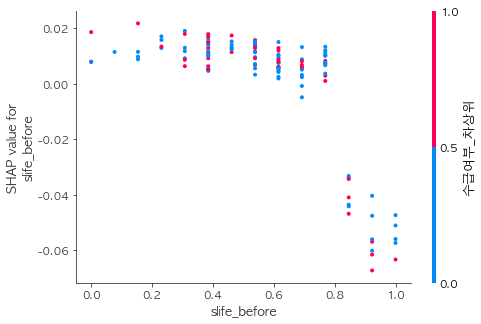

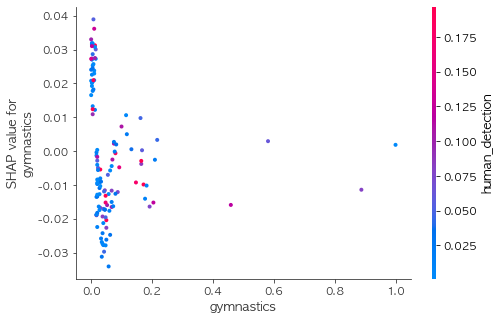

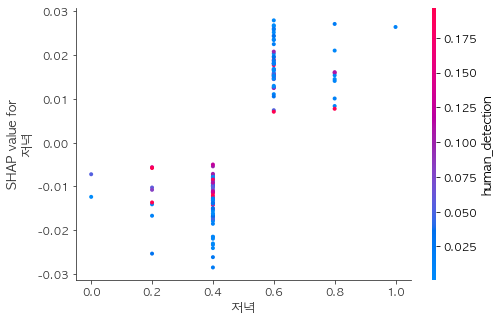

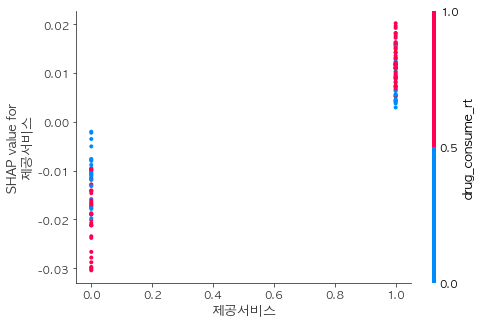

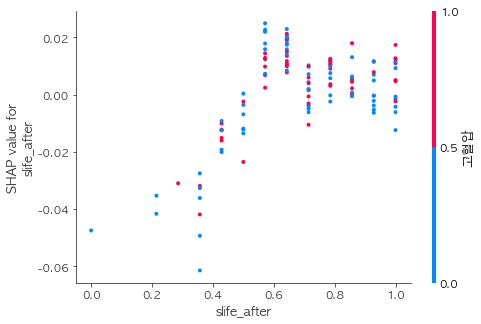

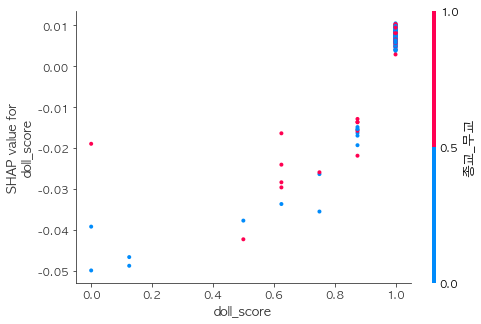

In [62]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[1]), 0))

for i in range(12):
    shap.dependence_plot(top_inds[i], shap_values[1], X_train_selected)

# Lime

In [60]:
import lime
import lime.lime_tabular

In [91]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train_selected),
                                                   training_labels = Y3_train.values, 
                                                   feature_names=X_train_selected.columns,                              
                                                   verbose=False, 
                                                   mode='classification', 
                                                   discretize_continuous=False)

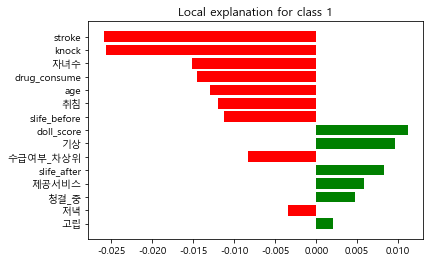

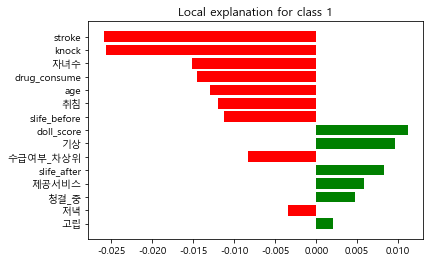

In [105]:
idx = 0
exp = explainer.explain_instance(X_test_selected.iloc[idx], rf.predict_proba, num_features=15)
exp.as_pyplot_figure()

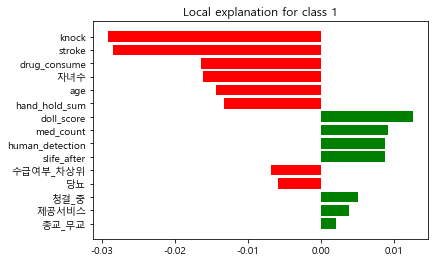

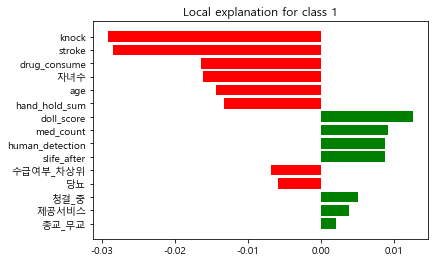

In [106]:
idx = 7
exp = explainer.explain_instance(X_test_selected.iloc[idx], rf.predict_proba, num_features=15)
exp.as_pyplot_figure()

In [101]:
exp.show_in_notebook(show_table=True, show_all=False)